In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
from sklearn.model_selection import train_test_split
import random
import torch.nn.functional as F
import torch.utils.data as data_utils

In [2]:
# Load data
data_error = pd.read_csv('PdM_errors.csv')
data_maint = pd.read_csv('PdM_maint.csv')
data_failures = pd.read_csv('PdM_failures.csv')
data_tele = pd.read_csv('PdM_telemetry.csv')
data_machines = pd.read_csv('PdM_machines.csv')


# Fill errors data csx

data_error['error1'] =0
data_error['error2'] =0
data_error['error3'] =0
data_error['error4'] =0
data_error['error5'] =0

for error in data_error.errorID:
    if error == 'error1':
        data_error.loc[data_error.errorID == error, 'error1'] = 1
    elif error == 'error2':
        data_error.loc[data_error.errorID == error, 'error2'] = 1
    elif error == 'error3':
        data_error.loc[data_error.errorID == error, 'error3'] = 1
    elif error == 'error4':
        data_error.loc[data_error.errorID == error, 'error4'] = 1
    elif error == 'error5':
        data_error.loc[data_error.errorID == error, 'error5'] = 1

data_error = data_error.drop(columns=['errorID'])
#print(data_error)

# Fill failures data csv

data_failures['component_1'] =0
data_failures['component_2'] =0
data_failures['component_3'] =0
data_failures['component_4'] =0

for failure in data_failures.failure:
    if failure == 'comp1':
        data_failures.loc[data_failures.failure == failure, 'component_1'] = 1
    elif failure == 'comp2':
        data_failures.loc[data_failures.failure == failure, 'component_2'] = 1
    elif failure == 'comp3':
        data_failures.loc[data_failures.failure == failure, 'component_3'] = 1
    elif failure == 'comp4':
        data_failures.loc[data_failures.failure == failure, 'component_4'] = 1

data_failures = data_failures.drop(columns=['failure'])
#print(data_failures)

#Fill maintenance data csv

data_maint['comp1_maint'] =0
data_maint['comp2_maint'] =0
data_maint['comp3_maint'] =0
data_maint['comp4_maint'] =0

for maint in data_maint.comp:
    if maint == 'comp1':
        data_maint.loc[data_maint.comp == maint, 'comp1_maint'] = 1
    elif maint == 'comp2':
        data_maint.loc[data_maint.comp == maint, 'comp2_maint'] = 1
    elif maint == 'comp3':
        data_maint.loc[data_maint.comp == maint, 'comp3_maint'] = 1
    elif maint == 'comp4':
        data_maint.loc[data_maint.comp == maint, 'comp4_maint'] = 1

data_maint = data_maint.drop(columns=['comp'])


#print(data_maint)

# Merge telemetry and error data csv

error_tele = pd.merge(data_tele, data_error, on=['datetime', 'machineID'], how='left')

# Merge failures into error_tele

error_tele_fail = pd.merge(error_tele, data_failures, on=['datetime', 'machineID'], how='left')
#error_tele_fail

# Merge maintenance into error_tele_fail

etf_maint = pd.merge(error_tele_fail, data_maint, on=['datetime','machineID'], how='left')

# Merge machines into etf_maint

final_dataframe = pd.merge(etf_maint, data_machines, on=['machineID'], how='left')
# replace NaN values with 0
final_dataframe = final_dataframe.fillna(0)

# group by machineID and datetime so that there is only one row per machine per datetime
final_dataframe = final_dataframe.groupby(['machineID', 'datetime']).max()

#final_dataframe

# Save the final dataframe to a csv file
final_dataframe.to_csv('final_dataframe_with_datetime_final.csv')

In [4]:
# Load the dataset

data = pd.read_csv('final_dataframe_with_datetime_final.csv')

# copy data to create new df to add columns for component failures
temp = data.copy()

# add columns for component failures in a day
temp['comp1_fails_day'] = temp['component_1']

# fill each of the columns with the number of component failures in a day
day= 24

for i in range(0, len(temp)):
    if temp.iloc[i,11]== 1:
        id = temp.iloc[i,0]


        for j in range(i , max(-1,i-day) , -1):

            if id != temp.iloc[j,0]:
                break
            temp.at[j, 'comp1_fails_day'] = 1

temp['comp2_fails_day'] = temp['component_2']

day= 24
for i in range(0, len(temp)):
    if temp.iloc[i,12]== 1:
        id = temp.iloc[i,0]
        for j in range(i , max(-1,i-day) , -1):
            if id != temp.iloc[j,0]:
                break
            temp.at[j, 'comp2_fails_day'] = 1
temp['comp3_fails_day'] = temp['component_3']

day= 24
for i in range(0, len(temp)):
    if temp.iloc[i,13]== 1:
        id = temp.iloc[i,0]
        for j in range(i , max(-1,i-day) , -1):
            if(id != temp.iloc[j,0]):
                break
            temp.at[j, 'comp3_fails_day'] = 1

day= 24
temp['comp4_fails_day'] = temp['component_4']
for i in range(0, len(temp)):
    if temp.iloc[i,14]== 1:
        id = temp.iloc[i,0]
        for j in range(i , max(-1,i-day) , -1):
            if id != temp.iloc[j,0]:
                break
            temp.at[j, 'comp4_fails_day'] = 1

temp.to_csv('temp.csv')



temp = pd.read_csv('temp.csv')
temp = temp.drop(columns=['Unnamed: 0'])

temp2 = temp.copy()

In [5]:
# Create a list of features
features_col = ['volt', 'rotate', 'pressure', 'vibration','age', 'error1', 'error2', 'error3', 'error4', 'comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint']

target_col_day = ['comp1_fails_day', 'comp2_fails_day', 'comp3_fails_day', 'comp4_fails_day']

In [6]:
train = pd.DataFrame(columns= temp.columns)
test = pd.DataFrame(columns= temp.columns)

from sklearn.preprocessing import MinMaxScaler

df = temp2

for i in range(1,101):
  k = df[df['machineID'] == i][:6503]
  train = train._append(k)
  k = df[df['machineID'] == i][6503:]
  test = test._append(k)

scaler = MinMaxScaler()

train[features_col] = scaler.fit_transform(train[features_col])
test[features_col] = scaler.transform(test[features_col])


seq_cols = features_col

def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros._append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,labels):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros._append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append([id_df[labels[0]][stop],id_df[labels[1]][stop],id_df[labels[2]][stop],id_df[labels[3]][stop]])
    return np.array(y_label)

In [ ]:
# generate X_train
day=48
X_train=np.concatenate(list(list(gen_sequence(train[train['machineID']==id], day, seq_cols)) for id in train['machineID'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(train[train['machineID']==id], day, seq_cols,target_col_day) for id in train['machineID'].unique())))
print(y_train.shape)
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(test[test['machineID']==id], day, seq_cols)) for id in test['machineID'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(test[test['machineID']==id], day, seq_cols,target_col_day)) for id in test['machineID'].unique()))
print(y_test.shape)
y_train = list(np.transpose(y_train))
y_test = list(np.transpose(y_test))

(650200, 48, 13)


In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    def make_default_hidden_layers(self, inputs):
        x = LSTM(units=50, return_sequences=True)(inputs)
        x = Dropout(0.2)(x)
        x = LSTM(units=50, return_sequences=False)(x)  # Use the output of the previous layer (changed (inputs) to (x))
        x = Dropout(0.2)(x)
        return x
    def build_comp1_branch(self, inputs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="comp1")(x)
        return x
    def build_comp2_branch(self, inputs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="comp2")(x)
        return x
    def build_comp3_branch(self, inputs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="comp3")(x)
        return x

    def build_comp4_branch(self, inputs):
        x = self.make_default_hidden_layers(inputs)
        x = Dense(1)(x)
        x = Activation("sigmoid", name="comp4")(x)
        return x
    def assemble_full_model(self, timestamp, nb_features):
        input_shape=(timestamp, nb_features)
        inputs = Input(shape=input_shape)
        branch1 = self.build_comp1_branch(inputs)
        branch2 = self.build_comp2_branch(inputs)
        branch3 = self.build_comp3_branch(inputs)
        branch4 = self.build_comp4_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [branch1,branch2,branch3,branch4],
                     name="failure")
        return model
nb_features =X_train.shape[2]
#print(nb_features)
timestamp=day


model = UtkMultiOutputModel().assemble_full_model(timestamp,nb_features)
model.summary()

Model: "failure"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 13)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 48, 50)               12800     ['input_1[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, 48, 50)               12800     ['input_1[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               (None, 48, 50)               12800     ['input_1[0][0]']             
                                                                                            

In [ ]:
# added to incorporate the custom metrics (recall_m, precision_m, f1_m)

from tensorflow.keras.metrics import Metric

class RecallMetric(Metric):
    def __init__(self, name='recall_metric', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))

        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)

class PrecisionMetric(Metric):
    def __init__(self, name='precision_metric', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)
        true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
        predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))

        self.true_positives.assign_add(true_positives)
        self.predicted_positives.assign_add(predicted_positives)

    def result(self):
        return self.true_positives / (self.predicted_positives + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = PrecisionMetric()
        self.recall = RecallMetric()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [ ]:
# edited to make use of custom metrics
model.compile(optimizer='adam',
              loss={
                  'comp1': 'binary_crossentropy',
                  'comp2': 'binary_crossentropy',
                  'comp3': 'binary_crossentropy',
                  'comp4': 'binary_crossentropy'},
              loss_weights={
                  'comp1': 1.0,  # Adjusting loss weights to sum to 1
                  'comp2': 1.0,
                  'comp3': 1.0,
                  'comp4': 1.0},
              metrics={
                  'comp1': [RecallMetric(), PrecisionMetric(), F1Score()],
                  'comp2': [RecallMetric(), PrecisionMetric(), F1Score()],
                  'comp3': [RecallMetric(), PrecisionMetric(), F1Score()],
                  'comp4': [RecallMetric(), PrecisionMetric(), F1Score()]})



model.fit(X_train, y_train, epochs=3, batch_size=100, validation_split=0.2)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Epoch 1/3
5202/5202 [==============================] - ETA: 0s - loss: 0.0507 - comp1_loss: 0.0136 - comp2_loss: 0.0068 - comp3_loss: 0.0121 - comp4_loss: 0.0182 - comp1_recall_metric: 0.5707 - comp1_precision_metric: 0.8225 - comp1_f1_score: 0.6738 - comp2_recall_metric: 0.8498 - comp2_precision_metric: 0.9495 - comp2_f1_score: 0.8969 - comp3_recall_metric: 0.4551 - comp3_precision_metric: 0.6916 - comp3_f1_score: 0.5490 - comp4_recall_metric: 0.0083 - comp4_precision_metric: 0.1164 - comp4_f1_score: 0.0156

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric RecallMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric PrecisionMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2723: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


5202/5202 [==============================] - 189s 33ms/step - loss: 0.0507 - comp1_loss: 0.0136 - comp2_loss: 0.0068 - comp3_loss: 0.0121 - comp4_loss: 0.0182 - comp1_recall_metric: 0.5707 - comp1_precision_metric: 0.8225 - comp1_f1_score: 0.6738 - comp2_recall_metric: 0.8498 - comp2_precision_metric: 0.9495 - comp2_f1_score: 0.8969 - comp3_recall_metric: 0.4551 - comp3_precision_metric: 0.6916 - comp3_f1_score: 0.5490 - comp4_recall_metric: 0.0083 - comp4_precision_metric: 0.1164 - comp4_f1_score: 0.0156 - val_loss: 0.0243 - val_comp1_loss: 0.0054 - val_comp2_loss: 1.2376e-04 - val_comp3_loss: 0.0050 - val_comp4_loss: 0.0138 - val_comp1_recall_metric: 0.8957 - val_comp1_precision_metric: 0.8716 - val_comp1_f1_score: 0.8835 - val_comp2_recall_metric: 1.0000 - val_comp2_precision_metric: 1.0000 - val_comp2_f1_score: 1.0000 - val_comp3_recall_metric: 0.8831 - val_comp3_precision_metric: 0.9410 - val_comp3_f1_score: 0.9112 - val_comp4_recall_metric: 0.0000e+00 - val_comp4_precision_metric

In [ ]:
# Change to extracting predictions
y_pred_comp1, y_pred_comp2, y_pred_comp3, y_pred_comp4 = model.predict(X_test)

y_target_comp1, y_target_comp2, y_target_comp3, y_target_comp4 = y_test

# Streamlined
y_pred_classes_comp1 = (y_pred_comp1 >= 0.5).astype(int)
y_pred_classes_comp2 = (y_pred_comp2 >= 0.5).astype(int)
y_pred_classes_comp3 = (y_pred_comp3 >= 0.5).astype(int)
y_pred_classes_comp4 = (y_pred_comp4 >= 0.5).astype(int)

7054/7054 [==============================] - 73s 10ms/step


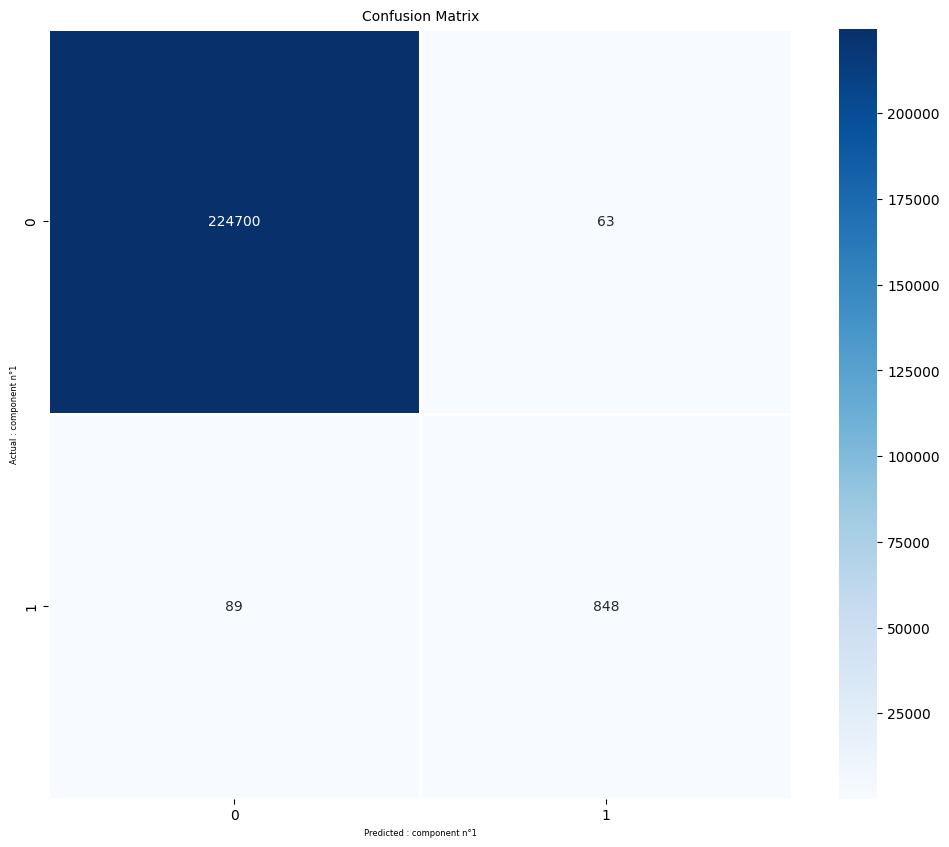

Accuracy :  0.9993265396544085
Recall :  0.9050160085378869
Precision :  0.9308452250274424
F1 score :  0.9177489177489178


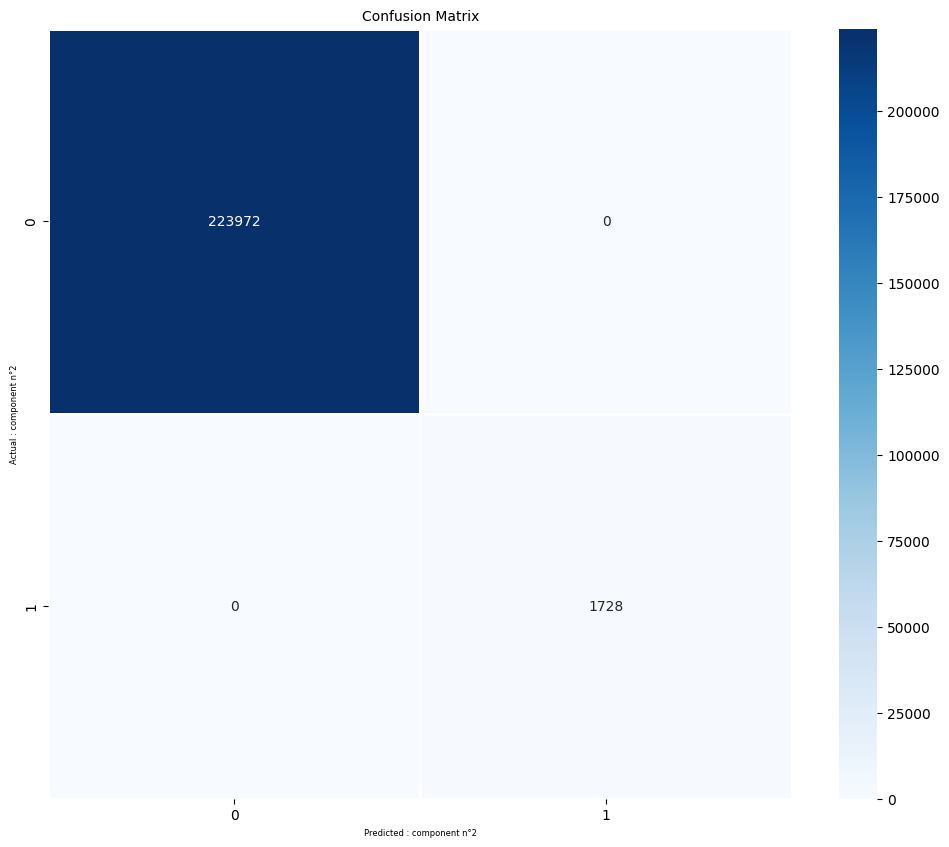

Accuracy :  1.0
Recall :  1.0
Precision :  1.0
F1 score :  1.0


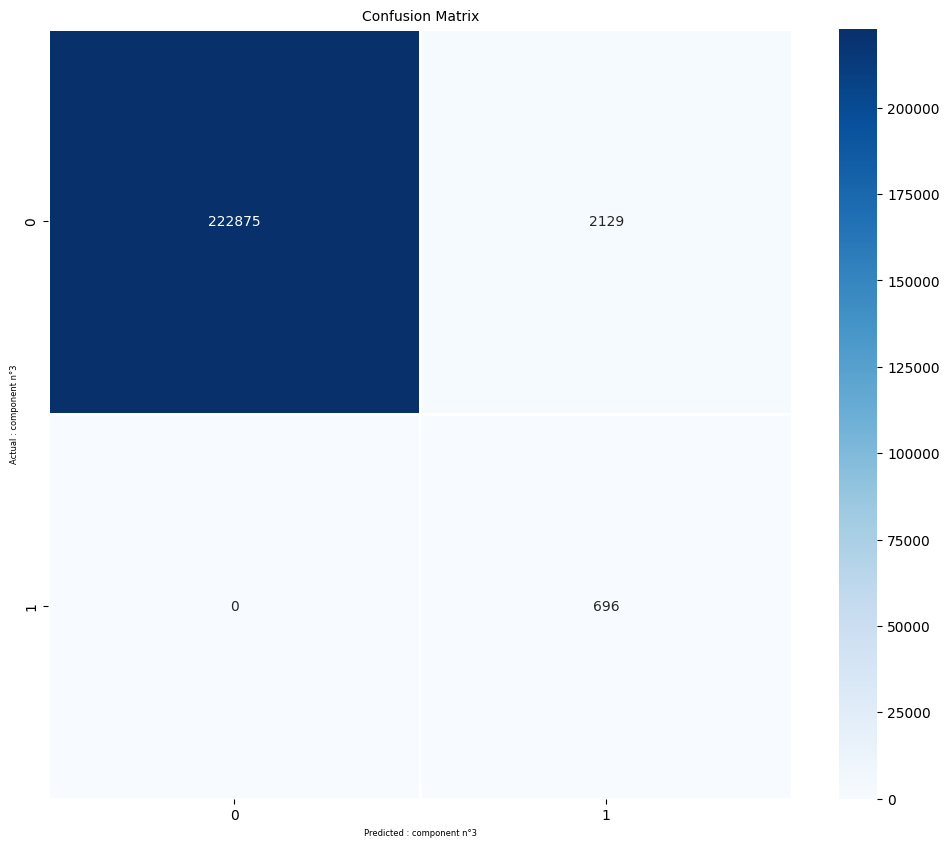

Accuracy :  0.9905671245015507
Recall :  1.0
Precision :  0.24637168141592922
F1 score :  0.3953422323203636


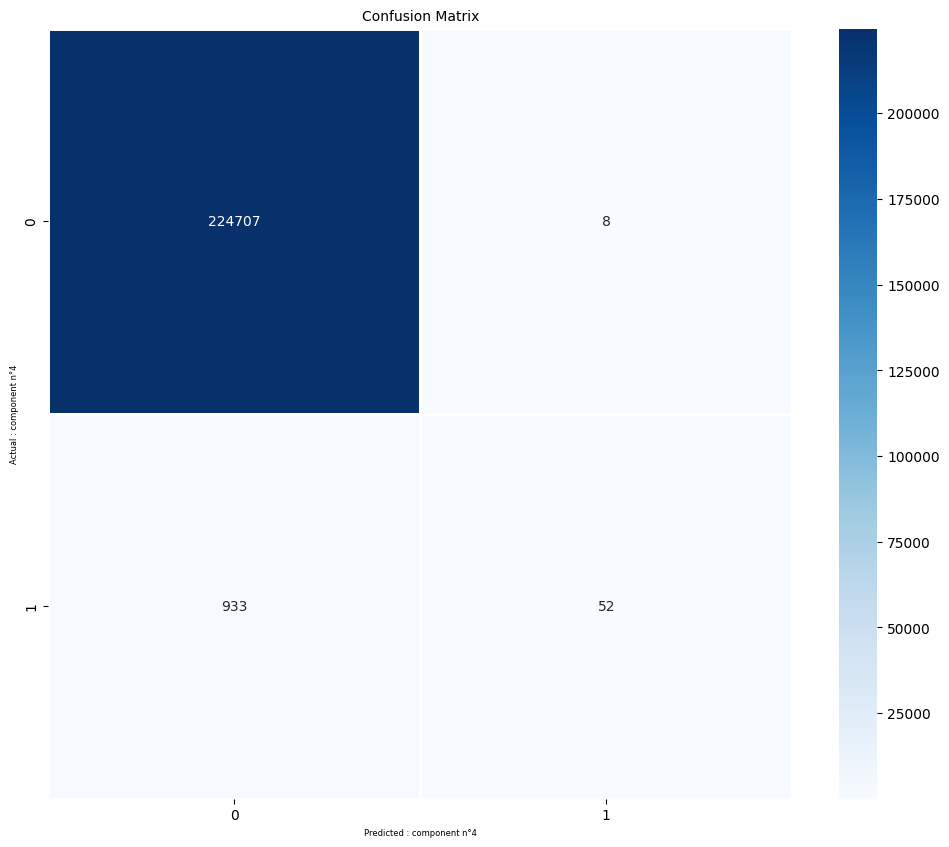

Accuracy :  0.9958307487815684
Recall :  0.05279187817258883
Precision :  0.8666666666666667
F1 score :  0.09952153110047848


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

def conf_mat(y_true , y_pred_classes , name):
  cm = confusion_matrix(y_true,y_pred_classes)
  plt.figure(figsize = (12, 10))
  cm = pd.DataFrame(cm , index = [0,1] , columns = [0,1])
  sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=10)
  plt.xlabel('Predicted : '+name , size=6)
  plt.ylabel('Actual : '+name ,size=6)
  plt.show()
  return cm
def performance(cm):
  #Accuracy
  print('Accuracy : ', (cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][0]+cm[0][1]+cm[1][1]))
  #Recall
  recall = (cm[1][1]/(cm[1][1]+cm[0][1]))
  print('Recall : ', recall )
  #Precision
  precision = (cm[1][1]/(cm[1][1]+cm[1][0]))
  print('Precision : ', precision )
  #F1 Score
  print('F1 score : ',2*precision*recall/(precision+recall))
performance(conf_mat(y_target_comp1, y_pred_classes_comp1, 'component n°1'))
performance(conf_mat(y_target_comp2, y_pred_classes_comp2, 'component n°2'))
performance(conf_mat(y_target_comp3, y_pred_classes_comp3, 'component n°3'))
performance(conf_mat(y_target_comp4, y_pred_classes_comp4, 'component n°4'))

In [ ]:
def compute_failure_probability(machine_id, comp):
    # Assuming 'test' is the DataFrame, 'day' is the sequence length, and 'seq_cols' are the columns used for prediction
    machine_df = test[test.machineID == machine_id]
    machine_test = gen_sequence(machine_df, day, seq_cols)

    # Predict using the model
    m_pred = model.predict(machine_test)

    # Extract the failure probability for the specified component from the last prediction sequence
    failure_prob = m_pred[comp][-1][0] * 100  # Adjusted for clarity; ensures compatibility with expected model output format

    return failure_prob

In [ ]:
# save the model and weights
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load the model and weights
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# test the model
print(compute_failure_probability(93,0))
print(compute_failure_probability(93,1))
print(compute_failure_probability(93,2))
print(compute_failure_probability(93,3))
print(compute_failure_probability(80,0))

71/71 [==============================] - 5s 11ms/step
0.00012981757890884182
71/71 [==============================] - 1s 9ms/step
0.0004923086180497194
71/71 [==============================] - 1s 9ms/step
0.0020386190954013728
71/71 [==============================] - 1s 8ms/step
44.84091103076935
71/71 [==============================] - 1s 8ms/step
0.021167252270970494
